In [ ]:
!pip install category_encoders

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Import des données

In [ ]:
data = pd.read_csv('train.csv', sep=",")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Analyse exploratoire


*   Sélection des variables explicatives du prix de vente
*   Enrichissement



In [ ]:
def df_nan(df, spe_colonne=True):
    """
    """
    line_with_nan = df.isna().apply(lambda x: 1 if sum(x) > 0 else 0, axis=1)
    print(f"Nombre de lignes avec nan: {line_with_nan.sum()} - {line_with_nan.sum()/df.shape[0] * 100}")
    if line_with_nan.sum():
        colonne_with_nan = df.isna().apply(lambda x: 1 if sum(x) > 0 else 0, axis=0)
        print(f"Nombre de colonnes avec Nan: {colonne_with_nan.sum()} - {colonne_with_nan.sum()/df.shape[1] * 100}")
        if spe_colonne and line_with_nan.sum():
            print("Colonnes avec des Nan et leur nombre:")
            print((df.isnull().sum().nlargest(sum(df.isnull().any())) / df.shape[0]) * 100)

In [ ]:
df_nan(data, spe_colonne=True)

Nombre de lignes avec nan: 1460 - 100.0
Nombre de colonnes avec Nan: 19 - 23.456790123456788
Colonnes avec des Nan et leur nombre:
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


In [ ]:
data.drop(['Id','Alley'],axis=1,inplace=True)

In [ ]:
features= data.columns
print(features)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

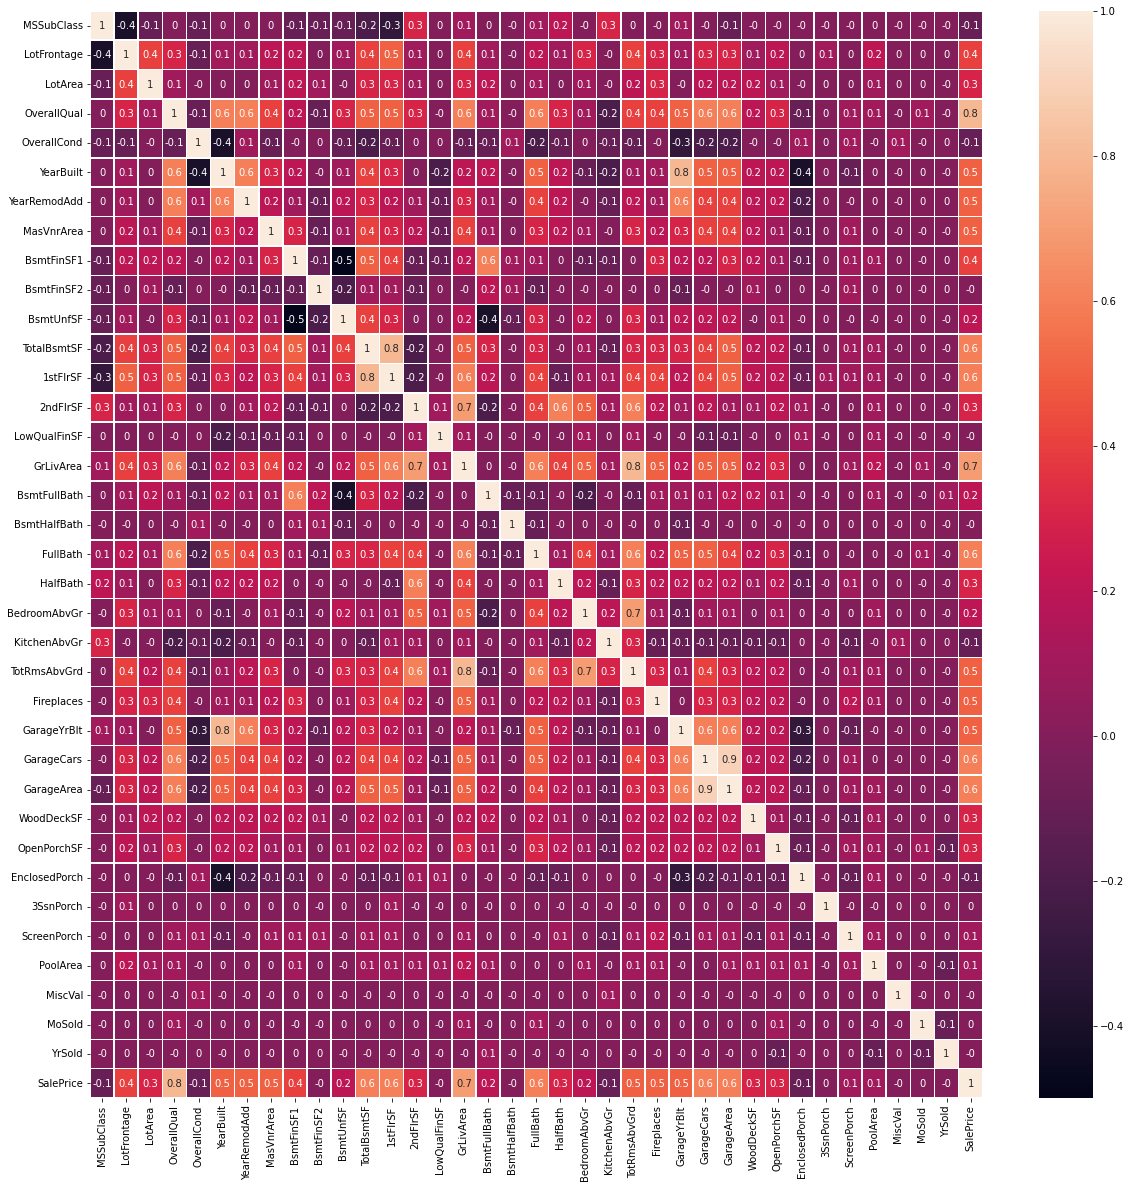

In [ ]:
matrice_corr = data.corr().round(1)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data=matrice_corr, annot=True, linewidths=.5, ax=ax)

In [ ]:
len(features)

79

In [ ]:
def nullTonull(x):
  if pd.isna(x):
    x = str(x)
  return x


In [ ]:
data["PoolQC"] = data["PoolQC"].map(lambda x: 0 if x is np.nan else 1)

In [ ]:
data[data["PoolQC"] == 1]["SalePrice"].mean()

288138.5714285714

In [ ]:
data[data["PoolQC"] == 0 & (data["BedroomAbvGr"] >= 3) & (data["BedroomAbvGr"] < 6) & (data["OverallQual"] > 5) & (data["OverallQual"] < 14000)]["SalePrice"].mean()

180404.66345492084

In [ ]:
null =data.isnull().sum()
print(null)

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 79, dtype: int64


In [ ]:
for i in range(len(null)):
  if null[i] != 0 :
    data[features[i]]=data[features[i]].apply(lambda x : nullTonull(x))

In [ ]:
data["Pieces"] = data['TotRmsAbvGrd'] - data['BedroomAbvGr']

In [ ]:
data["YearBuilt"] = data["YearBuilt"].apply(lambda x: 2022 - x)

In [ ]:
data['LotArea'] = data['LotArea'] / 10.764
data['LotArea'] = data['LotArea'].round(0)

In [ ]:
indices = list(data[data['LotArea'] >= 500].index)

data['LotArea'] = data['LotArea'].drop(index=indices)

In [ ]:
data["M2_per_piece"] = data['LotArea']/data['BedroomAbvGr']

In [ ]:
data.groupby(["YrSold", "MoSold"])["SalePrice"].mean()

YrSold  MoSold
2006    1         201090.000000
        2         194322.222222
        3         184982.200000
        4         174312.814815
        5         158928.289474
        6         172283.333333
        7         183211.059701
        8         196239.956522
        9         223768.866667
        10        172356.708333
        11        213285.000000
        12        185545.000000
2007    1         183234.615385
        2         176301.750000
        3         176567.782609
        4         170772.608696
        5         169873.511628
        6         179725.813559
        7         195396.843137
        8         183941.075000
        9         195533.818182
        10        215428.812500
        11        197709.333333
        12        214414.500000
2008    1         178504.692308
        2         159370.000000
        3         178505.277778
        4         159293.346154
        5         188334.473684
        6         169730.941176
        7         174562.

In [ ]:
from collections import Counter
Counter(data['BldgType'])

Counter({'1Fam': 1220, '2fmCon': 31, 'Duplex': 52, 'Twnhs': 43, 'TwnhsE': 114})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


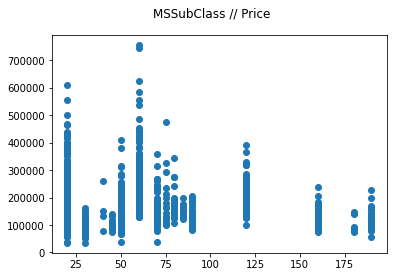

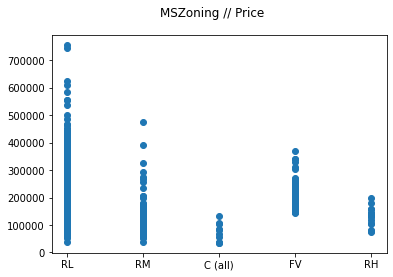

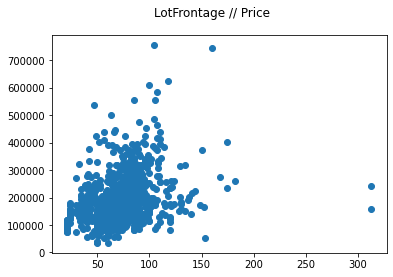

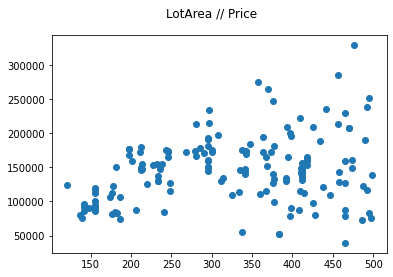

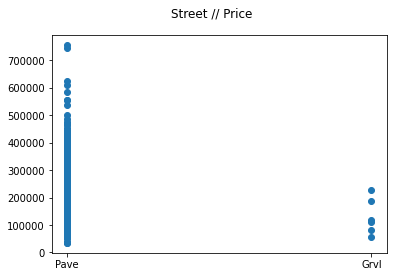

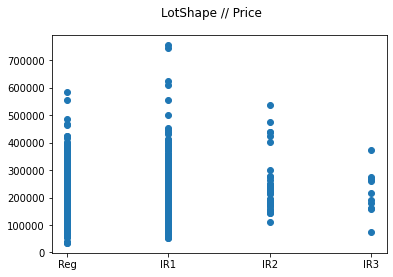

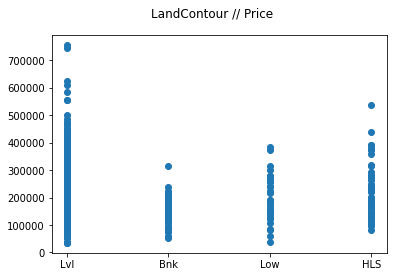

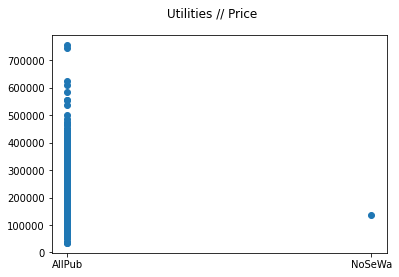

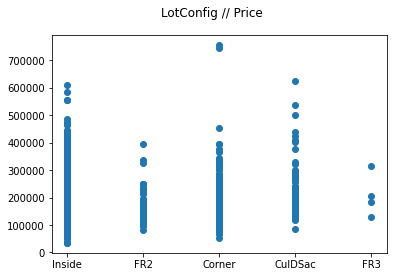

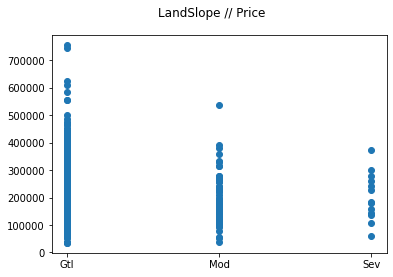

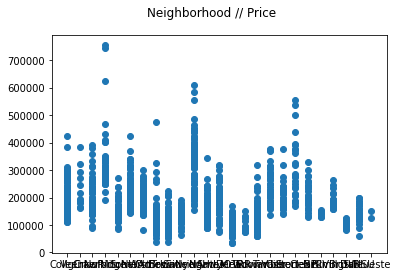

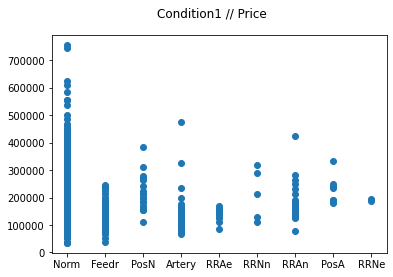

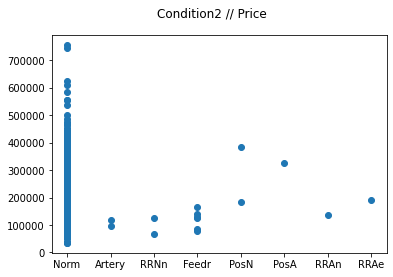

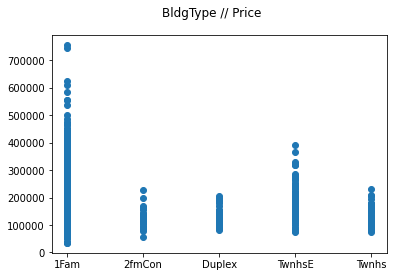

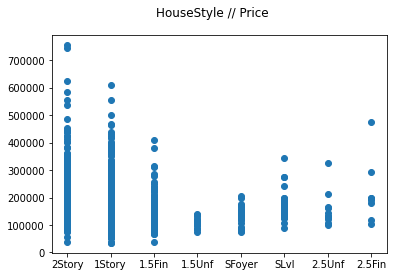

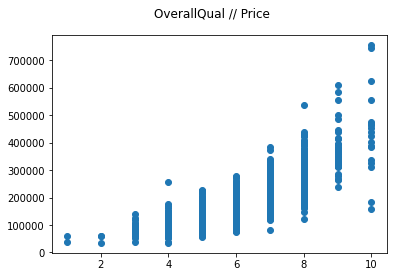

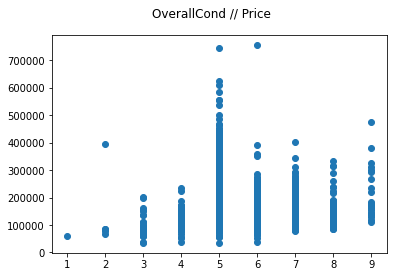

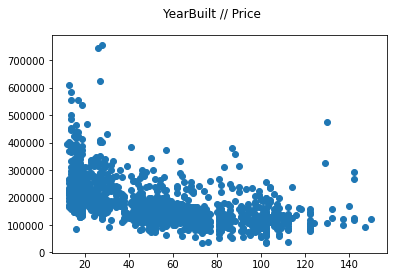

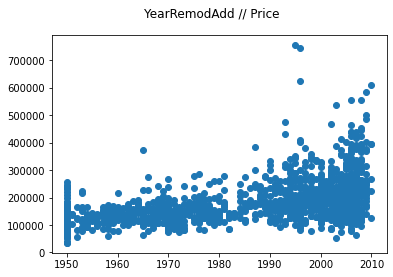

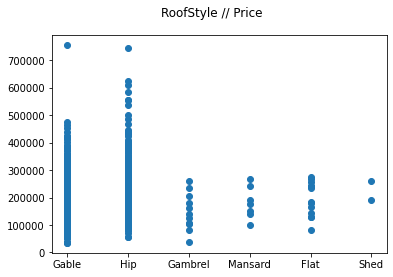

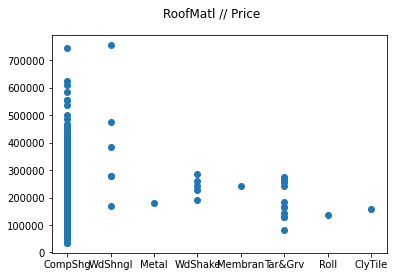

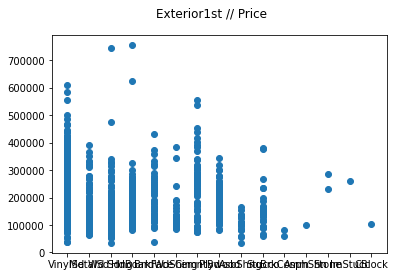

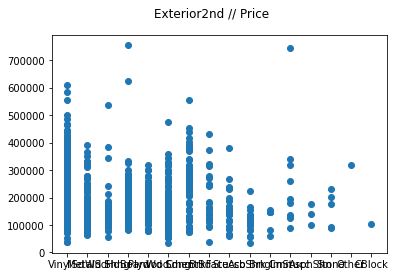

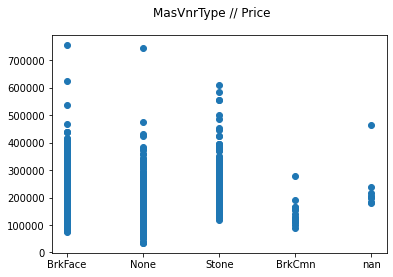

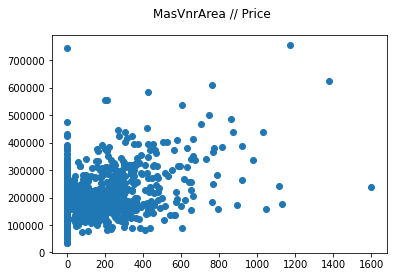

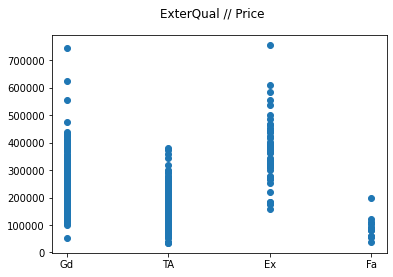

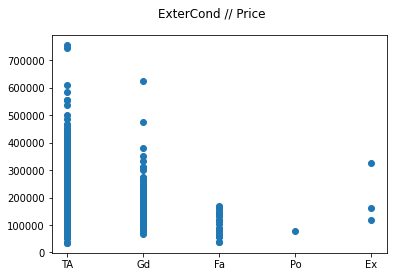

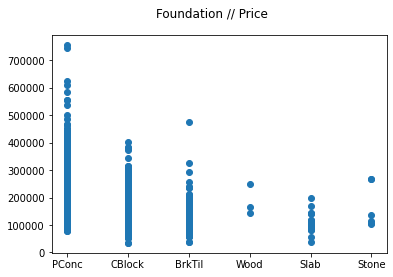

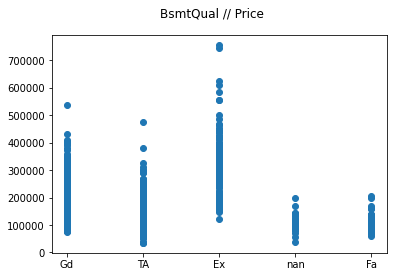

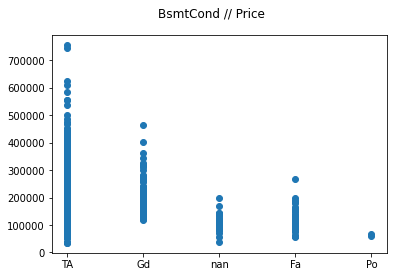

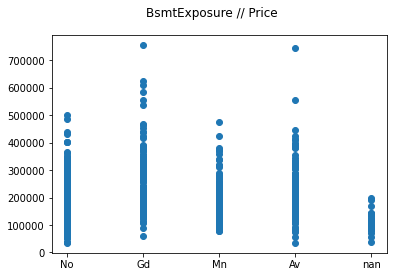

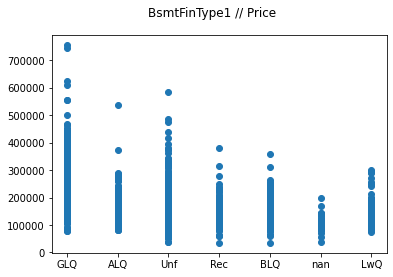

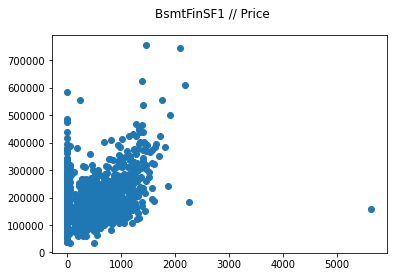

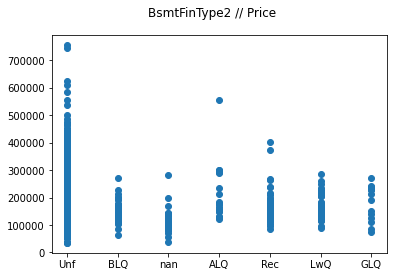

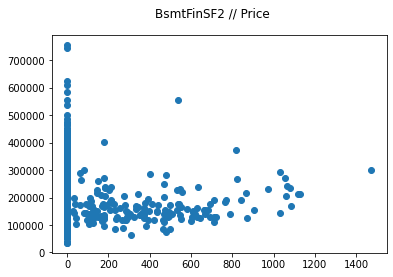

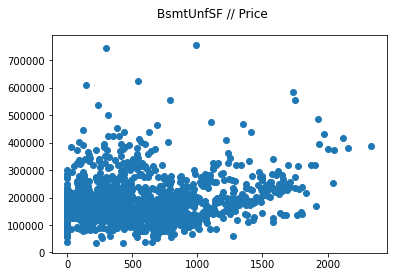

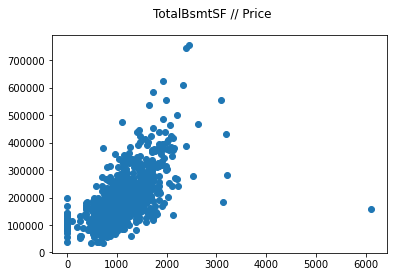

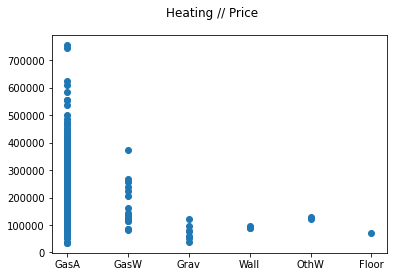

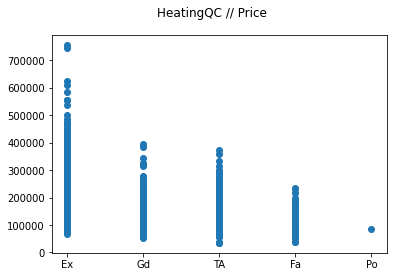

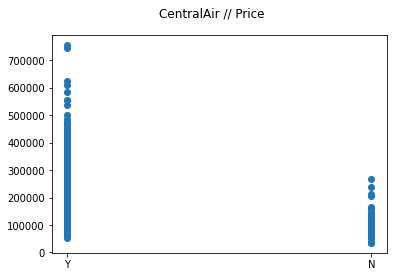

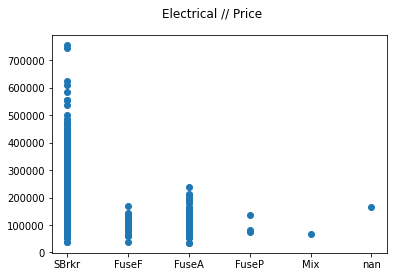

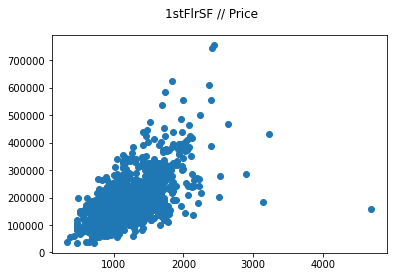

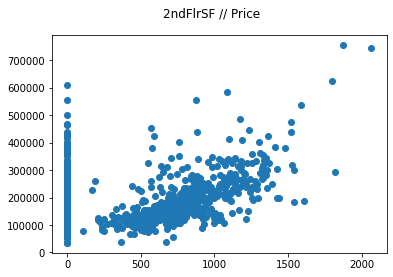

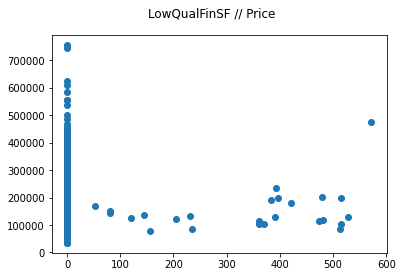

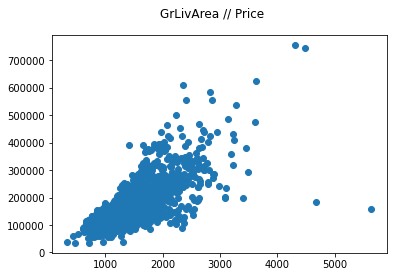

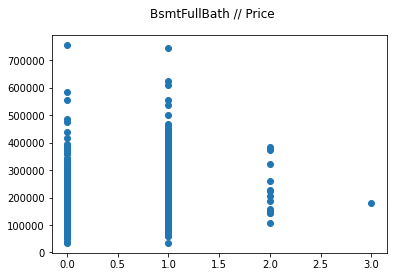

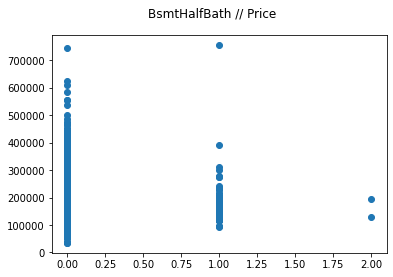

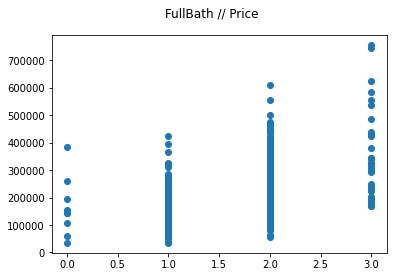

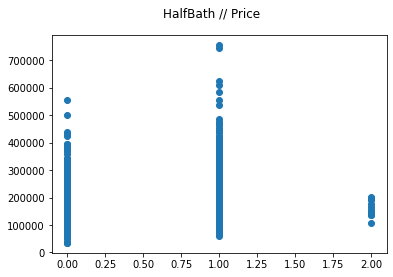

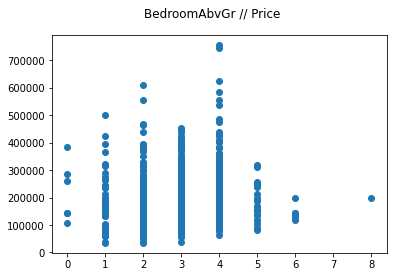

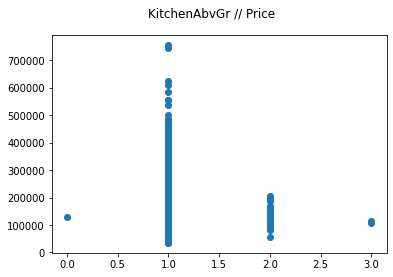

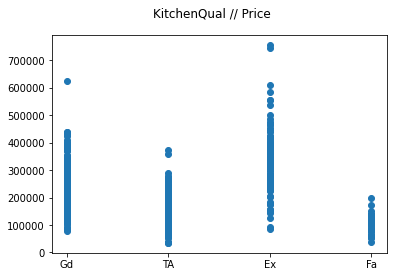

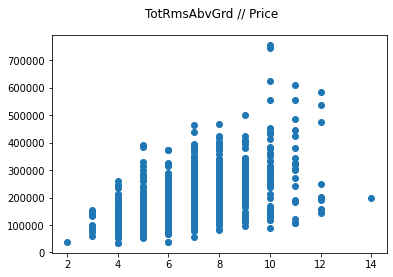

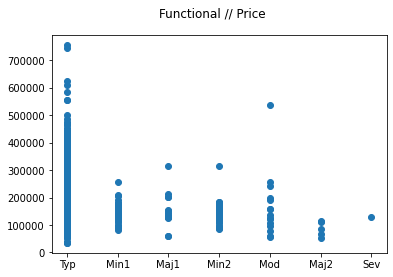

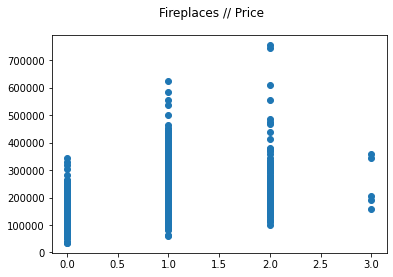

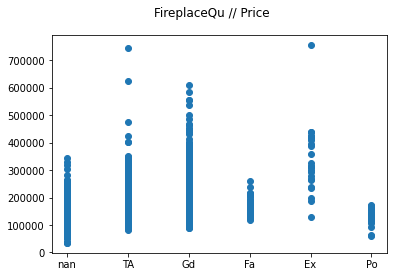

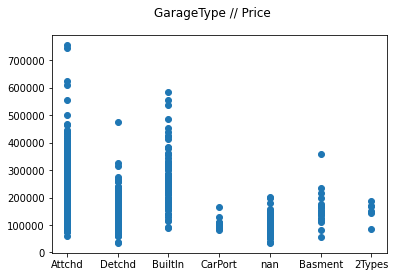

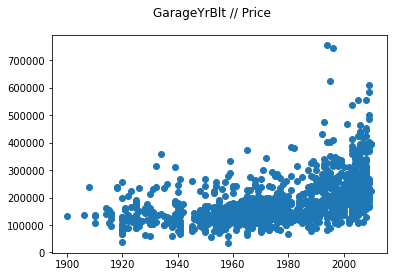

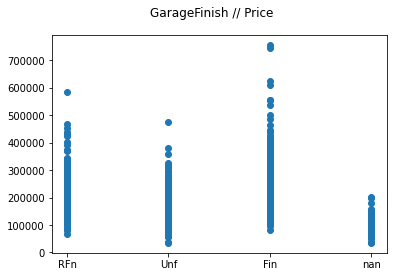

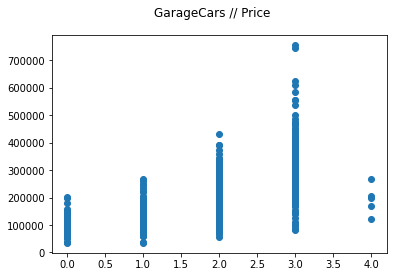

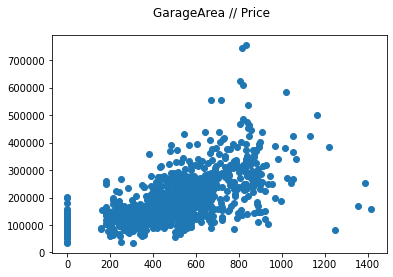

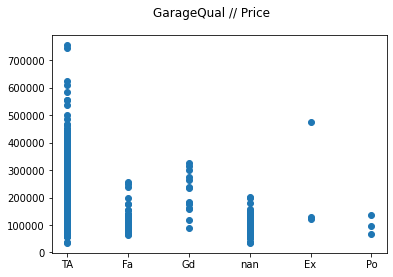

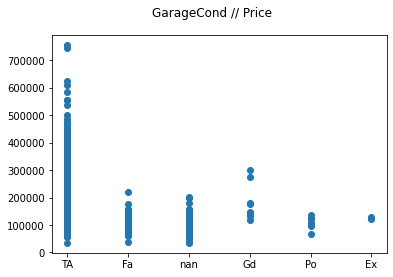

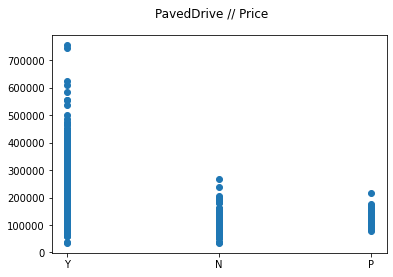

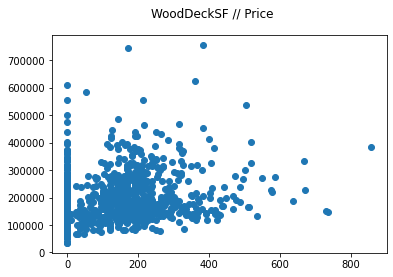

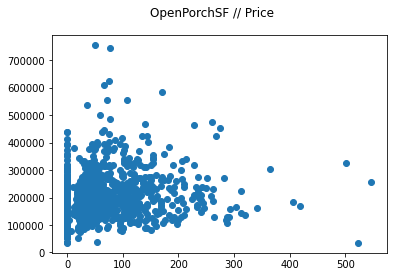

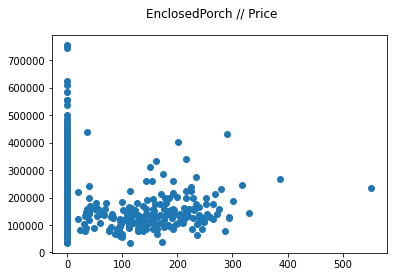

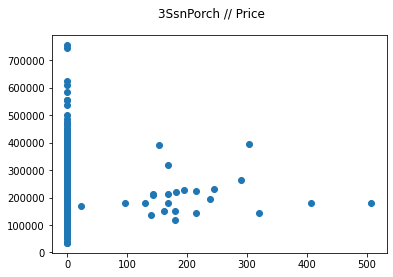

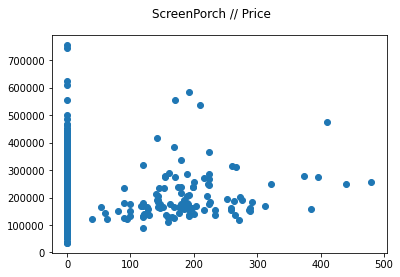

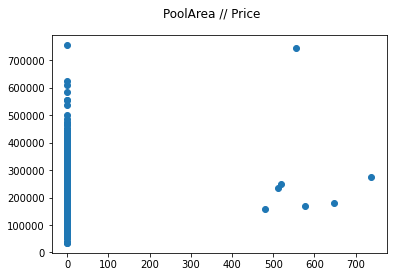

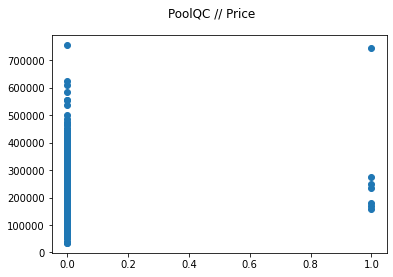

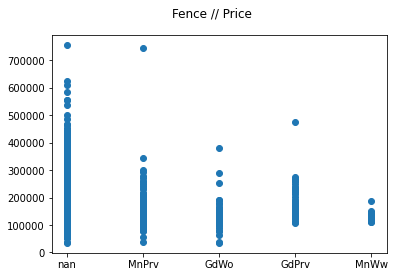

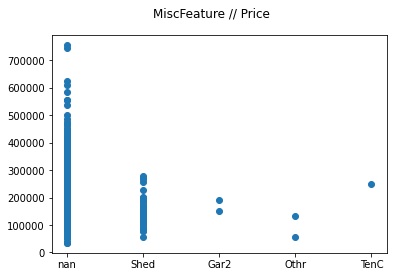

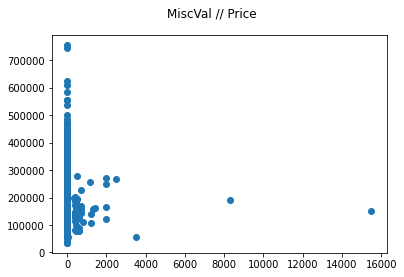

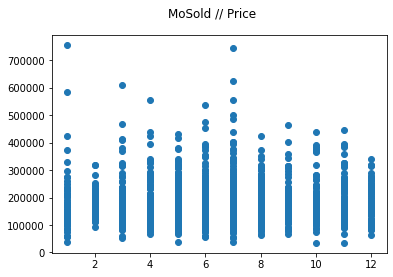

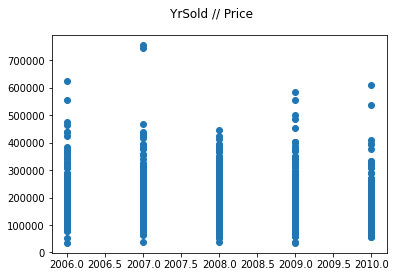

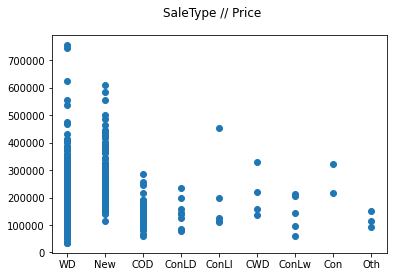

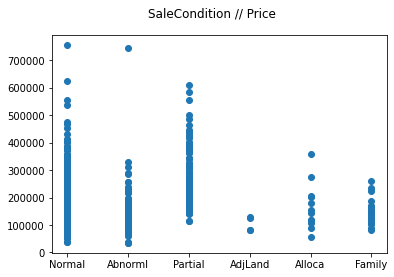

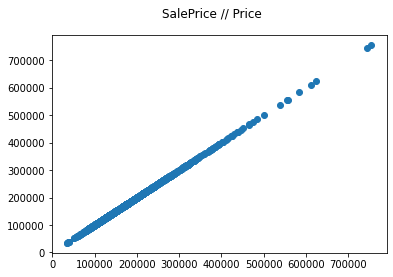

In [ ]:
for i in range(0,len(features)):
  try :
    plt.figure()
    plt.scatter(data[features[i]],data["SalePrice"])
    plt.suptitle(features[i]+" // Price ")
  except :
    print(features[i])

## Pre-processing

### Retrait des variables inutiles

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [ ]:
to_drop = ["Fence", "YrSold", "MoSold", "Condition2", "KitchenAbvGr", "3SsnPorch",\
           "PoolArea", "MiscVal", "SaleCondition", "Utilities",\
           "Heating", "HeatingQC", "Street", "Alley", "GarageCond", "BsmtCond",\
           "MiscFeature", "YearRemodAdd", "RoofMatl", "LandContour", "LotConfig", "Id"]
data.drop(to_drop, axis=1, inplace=True)
to_drop_roro = ["Electrical", "MasVnrArea", "LotFrontage", "GarageYrBlt", "GarageQual"]
data.drop(to_drop_roro, axis=1, inplace=True)

In [ ]:
clm_missed=[]
for i in data.columns :
  if data[i].isnull().sum()> 0:
    print(i, data[i].isnull().sum())
    clm_missed.append(i)

MasVnrType 8
BsmtQual 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
FireplaceQu 690
GarageType 81
GarageFinish 81
PoolQC 1453


### Transformation de variables

In [ ]:
## Ajout de l'ancienneté

data["YearBuilt"] = data["YearBuilt"].apply(lambda x: 2022 - x)

In [ ]:
## Nombre de pièce n'étant pas des chambres

data["Pieces"] = data['TotRmsAbvGrd'] - data['BedroomAbvGr']

In [ ]:
## Conversion des "square feet" en m²

data['LotArea'] = data['LotArea'] // 10.764


In [ ]:
## Retrait des biens ayant une surface supérieure/égale à 500m²
indices = list(data[data['LotArea'] >= 500].index)
data['LotArea'].drop(index=indices)

## surface par pièce
data["M2_per_piece"] = data['LotArea']//data['BedroomAbvGr']



## changer les nan en string

replace_nan = [ "GarageType","MasVnrType"]
for f in replace_nan:
    data[f] = data[f].map(lambda x: "Unknown" if x is np.nan else x)

replace_nan =["FireplaceQu", "BsmtFinType2", "BsmtQual", "BsmtFinType1", \
              "GarageFinish", "BsmtExposure"]
for f in replace_nan:
    data[f] = data[f].map(lambda x: "Nan" if x is np.nan else x)

# PoolQc to eliminate, most of values are unknown (nan)
# cas particulier de la piscine
#data["PoolQC"] = data["PoolQC"].map(lambda x: 0 if x is np.nan else 1)


## TODO checker qu'il n'y a bien q'une seule colonne avec des nan
df_nan(data)


## on drop les dernieres lignes qui ont des nan et qui ne signifient rien
data.dropna(inplace = True)





Nombre de lignes avec nan: 1453 - 99.52054794520548
Nombre de colonnes avec Nan: 1 - 1.7857142857142856
Colonnes avec des Nan et leur nombre:
PoolQC    99.520548
dtype: float64


In [ ]:
## liste des ordinals
list_ordinal = ["FireplaceQu", "BsmtFinType2", "BsmtQual", "BsmtFinType1",
                     "ExterQual", "Functional", "KitchenQual", "BsmtExposure",
                     "ExterCond", "LandSlope","GarageFinish","CentralAir"]

## dico des correspondance valeur -> int

dico = {"Nan":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5, "No":1, "Mn":2, "Av":3, "Gd":4,
        "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6, "Gtl": 3, "Mod": 2, "Sev": 1,
        "Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0, "NA": 0, "Unf": 1, "RFn": 2, "Fin":3,"N":0,"Y":1}
#  PavedDrive : ordinal 
dic={'P':1,'Y':2,'N':0}
## changement des string en int pour les colonnes ordinals

data["PavedDrive"]= data["PavedDrive"].map(lambda x : dic[x])

for f in list_ordinal:
  data[f] = data[f].map(lambda x : dico[x])



In [ ]:
data["GarageFinish"].unique()

array([1, 2, 3])

In [ ]:
data

,MSSubClass,MSZoning,LotArea,LotShape,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,SaleType,SalePrice,Pieces,M2_per_piece
197,75,RL,2361.0,Reg,3,NAmes,Artery,1Fam,2Story,8,4,104,Gable,Stucco,Stucco,None,4,4,PConc,3,1,6,1036,2,184,140,1360,1,1360,1360,392,3112,1,1,2,0,4,4,8,7,1,5,Detchd,1,2,795,2,0,16,552,0,Ex,WD,235000,4,590.0
810,20,RL,942.0,Reg,3,NWAmes,Norm,1Fam,1Story,6,6,48,Hip,HdBoard,HdBoard,BrkFace,3,3,CBlock,3,1,5,663,2,377,0,1040,1,1309,0,0,1309,1,0,1,1,3,4,5,7,1,2,Attchd,2,2,484,2,265,0,0,0,Fa,WD,181000,2,314.0
1170,80,RL,917.0,Reg,3,Mitchel,Norm,1Fam,SLvl,6,6,45,Gable,Plywood,Plywood,None,3,3,CBlock,3,3,5,522,1,0,574,1096,1,1118,0,0,1118,1,0,1,0,3,3,6,7,1,1,Attchd,3,1,358,2,203,0,0,0,Gd,WD,171000,3,305.0
1182,60,RL,1451.0,IR1,3,NoRidge,Norm,1Fam,2Story,10,5,26,Hip,Wd Sdng,ImStucc,None,4,3,PConc,5,3,6,2096,1,0,300,2396,1,2411,2065,0,4476,1,0,3,1,4,5,10,7,2,3,Attchd,3,3,813,2,171,78,0,0,Ex,WD,745000,6,362.0
1298,60,RL,5935.0,IR3,3,Edwards,Feedr,1Fam,2Story,10,5,14,Hip,Stucco,Stucco,Stone,5,3,PConc,5,4,6,5644,1,0,466,6110,1,4692,950,0,5642,2,0,2,1,3,5,12,7,3,4,Attchd,3,2,1418,2,214,292,0,0,Gd,New,160000,9,1978.0
1386,60,RL,1550.0,IR1,3,NWAmes,RRAn,1Fam,2Story,7,5,44,Gable,Plywood,Plywood,BrkFace,3,3,CBlock,4,1,4,790,2,469,133,1392,1,1392,1392,0,2784,1,0,3,1,5,4,12,7,2,3,Attchd,2,2,564,2,0,112,0,440,Fa,WD,250000,7,310.0
1423,80,RL,1829.0,IR1,3,Edwards,Norm,1Fam,SLvl,6,7,56,Flat,Plywood,Plywood,None,4,4,CBlock,4,3,1,0,1,0,697,697,1,1575,626,0,2201,0,0,2,0,4,4,8,7,1,4,Attchd,1,2,432,2,586,236,0,0,Gd,WD,274970,4,457.0


### Dumification, standardisation

In [ ]:
data['MSSubClass'] = data['MSSubClass'].map({20:'1-S 1946',
                                             30:'1-S 1945',
                                             40:'1-S W/FINISHED',
                                             45:'1-1/2 S - UNF',
                                             50:'1-1/2 S FIN',
                                             60:'2-S 1946',
                                             70:'2-S 1945',
                                             75:'2-1/2 S ALL AGES',
                                             80:'SPLIT/MULTI-LEVEL',
                                             80:'SPLIT FOYER',
                                             90:'DUPLEX',
                                             120:'1-S PUD - 1946',
                                             150:'1-1/2 S PUD',
                                             160:'2-S PUD - 1946',
                                             180:'PUD / MULTILVL',
                                             190:'2 FAMILY CONV'
                                            },
                                            na_action=None)

In [ ]:
# features to dummy 
to_dummy = [ "MSSubClass","Neighborhood", "Exterior1st", "Exterior2nd", "MSZoning", "Condition1", \
            "HouseStyle","BldgType", "RoofStyle","MasVnrType","Foundation","SaleType","GarageType","LotShape"]
data=pd.get_dummies(data, columns = to_dummy, prefix=to_dummy)

#### second method  : encoding features with binary method
# features to encode ( binary encoding ) 
"""
to_encode =["MSZoning", "Condition1", "HouseStyle","BldgType", "RoofStyle","MasVnrType","Foundation","SaleType","GarageType","LotShape"]
 
import category_encoders as ce
encoders={}
for column in to_dummy :
  encoder = ce.BinaryEncoder(cols=[column])
  data = encoder.fit_transform(data)
  encoders[column]=encoder

data.head()
"""


'\nto_encode =["MSZoning", "Condition1", "HouseStyle","BldgType", "RoofStyle","MasVnrType","Foundation","SaleType","GarageType","LotShape"]\n \nimport category_encoders as ce\nencoders={}\nfor column in to_dummy :\n  encoder = ce.BinaryEncoder(cols=[column])\n  data = encoder.fit_transform(data)\n  encoders[column]=encoder\n\ndata.head()\n'

In [ ]:
data1=data
data1.sort_index(axis = 1, ascending = True)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BldgType_1Fam,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_RRAn,EnclosedPorch,ExterCond,ExterQual,Exterior1st_HdBoard,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_Plywood,Exterior2nd_Stucco,FireplaceQu,Fireplaces,Foundation_CBlock,Foundation_PConc,FullBath,Functional,GarageArea,GarageCars,GarageFinish,GarageType_Attchd,GarageType_Detchd,...,HouseStyle_2Story,HouseStyle_SLvl,KitchenQual,LandSlope,LotArea,LotShape_IR1,LotShape_IR3,LotShape_Reg,LowQualFinSF,M2_per_piece,MSSubClass_1-S 1946,MSSubClass_2-1/2 S ALL AGES,MSSubClass_2-S 1946,MSSubClass_SPLIT FOYER,MSZoning_RL,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Neighborhood_Edwards,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,OpenPorchSF,OverallCond,OverallQual,PavedDrive,Pieces,PoolQC,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Hip,SalePrice,SaleType_New,SaleType_WD,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt
197,1360,1360,4,1,1,1036,184,6,2,1,1,3,140,1,1,0,0,0,552,4,4,0,0,1,0,0,0,0,1,5,1,0,1,2,7,795,2,1,0,1,...,1,0,4,3,2361.0,0,0,1,392,590.0,0,1,0,0,1,0,1,0,0,0,1,0,0,16,4,8,2,4,Ex,0,1,0,235000,0,1,0,8,1360,0,104
810,1309,0,3,1,1,663,377,5,2,1,0,3,0,1,0,0,1,0,0,3,3,1,0,0,0,1,0,0,0,2,1,1,0,1,7,484,2,2,1,0,...,0,0,4,3,942.0,0,0,1,0,314.0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,6,6,2,2,Fa,0,0,1,181000,0,1,0,5,1040,265,48
1170,1118,0,3,1,3,522,0,5,1,1,0,3,574,1,0,0,1,0,0,3,3,0,1,0,0,0,0,1,0,1,1,1,0,1,7,358,1,3,1,0,...,0,1,3,3,917.0,0,0,1,0,305.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,6,6,2,3,Gd,0,1,0,171000,0,1,0,6,1096,203,45
1182,2411,2065,4,1,3,2096,0,6,1,1,0,5,300,1,0,0,1,0,0,3,4,0,0,0,1,0,1,0,0,3,2,0,1,3,7,813,3,3,1,0,...,1,0,5,3,1451.0,1,0,0,0,362.0,0,0,1,0,1,0,1,0,0,0,0,0,1,78,5,10,2,6,Ex,0,0,1,745000,0,1,0,10,2396,171,26
1298,4692,950,3,1,4,5644,0,6,1,2,0,5,466,1,0,1,0,0,0,3,5,0,0,1,0,0,0,0,1,4,3,0,1,2,7,1418,2,3,1,0,...,1,0,5,3,5935.0,0,1,0,0,1978.0,0,0,1,0,1,0,0,1,1,0,0,0,0,292,5,10,2,9,Gd,0,0,1,160000,1,0,0,12,6110,214,14
1386,1392,1392,5,1,1,790,469,4,2,1,0,4,133,1,0,0,0,1,0,3,3,0,1,0,0,0,0,1,0,3,2,1,0,3,7,564,2,2,1,0,...,1,0,4,3,1550.0,1,0,0,0,310.0,0,0,1,0,1,1,0,0,0,0,0,1,0,112,5,7,2,7,Fa,0,1,0,250000,0,1,440,12,1392,0,44
1423,1575,626,4,1,3,0,0,1,1,0,0,4,697,1,0,0,1,0,0,4,4,0,1,0,0,0,0,1,0,4,1,1,0,2,7,432,2,1,1,0,...,0,1,4,3,1829.0,1,0,0,0,457.0,0,0,0,1,1,0,1,0,1,0,0,0,0,236,7,6,2,4,Gd,1,0,0,274970,0,1,0,8,697,586,56


In [ ]:
np.isinf(data1).values.sum()

TypeError: ignored

In [ ]:
data1 = data1.replace([np.inf, -np.inf], np.nan)
data1.dropna(inplace = True)
data1.reset_index(drop = True, inplace = True)

In [ ]:
data2=data1.pop('SalePrice')
data2=data2.to_numpy().reshape(-1,1)

In [ ]:
sc1 = StandardScaler()
X = sc1.fit_transform(data1) 

nor = StandardScaler()
Y = nor.fit_transform(data2.reshape(-1, 1))
Y 

## Cross Validation

### Régression linéaire

In [ ]:
# Import des modules

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
cross_val_score(reg, X, Y, cv=4, scoring='neg_mean_squared_error')

### Random Forest

In [ ]:
clf = RandomForestRegressor(max_depth=4, random_state=0)
cross_val_score(clf, X, Y.reshape(-1,), cv=4, scoring='neg_mean_squared_error')

### Decision Tree

In [ ]:
regressor = DecisionTreeRegressor(random_state=0)
cross_val_score(regressor, X, Y, cv=4,scoring='neg_mean_squared_error')

## Evaluation des modèles

In [ ]:
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor()
parameters = {'n_estimators':[80, 100, 150], 'max_depth': [4, 5, 6, 8],
              'min_samples_split': [2,3]}


clf = GridSearchCV(rfr, parameters, scoring='neg_mean_squared_error')
result = clf.fit(X, Y.reshape(-1,))

In [ ]:
result.best_score_

In [ ]:
clf.best_estimator_